# Week 9

1. Configure the virtual environment according to the requirement document
2. Read in the data, check for outliers, delete the rows with missing values, and clean the data
3. For some key information in the data, draw a graph to view the distribution of the key information.
Add a P_M_Category column based on the Predicted_Mileage value and divide it into 3 categories. Draw and save histograms of Actual Mileage and Predicted_Mileage respectively. Draw and save pie charts of AM_Category and P_M_Category .
4. Start a systematic review of algorithms such as SVM and logistic regression

### Background and Task
##### Sharing economy:
Sharing economy has become one of the hottest directions in the field of data analysis. The resource allocation of sharing economy needs to be adjusted using data analysis methods.

##### The Task
This project uses four different machine learning algorithms to count the taxi orders received by a platform in a certain operating area in the morning, and obtains more than 40,000 order data. With the popularity of the platform and the growth of users, the proportion of canceled orders on the platform is also increasing significantly.
This project aims to use machine learning data analysis methods to establish a classification model for canceled orders, aiming to improve the current situation of a large number of canceled orders.

##### Dataset Introduction
About the dataset: There are 49015 sets of data, 9 different labels
About Label:
- time:order time
- ConnectTime:order connection time
- latest:latest mileage
- Predicted_Mileage: estimated mileage
- Credit Score: account credit score
- Membership Code: whether you are a member
- Actual Mileage: actual mileage
- Account_Category: different account types
- Temper Code: whether to use discounts
- Order Number: an order number of a different category

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
file_path = "data/Uber_N.csv"
uber_df = pd.read_csv(file_path)
uber_df = uber_df.drop('time', axis=1)
missing_mask = uber_df.isna().sum(axis=1) != 0
uber_df = uber_df.loc[~missing_mask, :]
uber_df['hour'] = pd.to_datetime(uber_df['ConnectTime'], format='%H:%M:%S').dt.hour
uber_df['credit'] = uber_df['Credit Score'].astype(int)
uber_df['member'] = uber_df['Membership Code'].astype(int)
uber_df['temper'] = uber_df['Temper Code'].astype(int)
uber_df['latest'] = uber_df['latest'].str.replace(',', '').astype(float)
uber_df['order'] = uber_df['Order Number'].astype(int)
uber_df.head()

,ConnectTime,latest,Predicted_Mileage,Actual Mileage,Credit Score,Membership Code,Temper Code,Order Number,hour,credit,member,temper,order
0,14:30:00,5285.0,23.0,23.0,91,True,True,392,14,91,1,1,392
1,14:30:00,5283.8,6.0,0.0,99,False,False,289,14,99,0,0,289
2,14:30:00,5283.8,6.0,0.0,81,True,False,57,14,81,1,0,57
3,14:30:00,5285.0,22.0,0.0,94,False,True,116,14,94,0,1,116
4,14:29:59,5284.8,2.0,2.0,100,True,False,561,14,100,1,0,561


In [3]:
def plot_p_a_mileage_line(df, bin_num=30, colors=['skyblue', 'salmon'], limit=30, save=False):

    bins = np.arange(0, limit + 1, 1)
    predicted_counts, _ = np.histogram(df['Predicted_Mileage'], bins=bins)
    predicted_bin_centers = (bins[:-1] + bins[1:]) // 2
    actual_counts, _ = np.histogram(df['Actual Mileage'], bins=bins)
    actual_bin_centers = (bins[:-1] + bins[1:]) // 2

    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    
    axes.plot(predicted_bin_centers, predicted_counts, marker='o', color=colors[0], label='Predicted Mileage')
    axes.plot(actual_bin_centers, actual_counts, marker='o', color=colors[1], label='Actual Mileage')

    axes.set_title('Distribution of Predicted vs Actual Mileage')
    axes.set_xlabel('Mileage')
    axes.set_ylabel('Frequency')

    axes.set_xlim(0, limit)
    axes.set_xticks(np.arange(0, limit + 1, 1))
    axes.legend()
    axes.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')

    if save:
        plt.savefig('p_a_mileage_line')
        print(f'p_a_mileage_line.png saved!')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_p_a_mileage_hist(df, bin_num=100, colors=['skyblue', 'salmon'], log=True, save=False):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(df['Predicted_Mileage'], bins=100, color='skyblue', kde=False, ax=axes[0])
    axes[0].set_title('Histogram of Predicted Mileage')
    axes[0].set_xlabel('Predicted Mileage')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, which='major', axis='both', linestyle='--', linewidth=0.7, color='gray')

    sns.histplot(df['Actual Mileage'], bins=100, color='salmon', kde=False, ax=axes[1])
    axes[1].set_title('Histogram of Actual Mileage')
    axes[1].set_xlabel('Actual Mileage')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, which='major', axis='both', linestyle='--', linewidth=0.7, color='gray')

    if log:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
        
    if save:
        plt.savefig('p_a_mileage_hist')
        print(f'p_a_mileage_hist.png saved!')

    plt.tight_layout()
    plt.show()

In [5]:
def plot_p_a_mileage_scatter(df, low_threshold=1, high_threshold=25, save_path='p_a_mileage_scatter'):
    short_rides_df = df[df['Predicted_Mileage'] <= low_threshold].copy()
    long_rides_df = df[df['Predicted_Mileage'] >= high_threshold].copy()

    np.random.seed(0)
    noise = np.random.normal(loc=0, scale=0.1, size=short_rides_df.shape[0])
    short_rides_df['Predicted_Mileage'] = short_rides_df.loc[:, 'Predicted_Mileage'] + noise

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(x=short_rides_df['Predicted_Mileage'], y=short_rides_df['Actual Mileage'], 
                    alpha=0.75, s=30, color='coral', edgecolor=None, ax=axes[0])
    axes[0].set_title(f'Predicted Mileage <= {low_threshold}')
    axes[0].set_xlabel('Predicted Mileage')
    axes[0].set_ylabel('Actual Mileage')
    axes[0].grid(True)

    lims = [0.66, 1.33]
    axes[0].plot(lims, lims, '-', color='red', linewidth=1.5)

    sns.scatterplot(x=long_rides_df['Predicted_Mileage'], y=long_rides_df['Actual Mileage'], 
                    alpha=0.75, s=30, color='skyblue', edgecolor=None, ax=axes[1])
    axes[1].set_title(f'Predicted Mileage >= {high_threshold}')
    axes[1].set_xlabel('Predicted Mileage')
    axes[1].set_ylabel('Actual Mileage')
    axes[1].grid(True)

    lims = [25, 250]
    axes[1].plot(lims, lims, '-', color='red', linewidth=1.5)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f'Pie charts saved to {save_path}')
    plt.show()

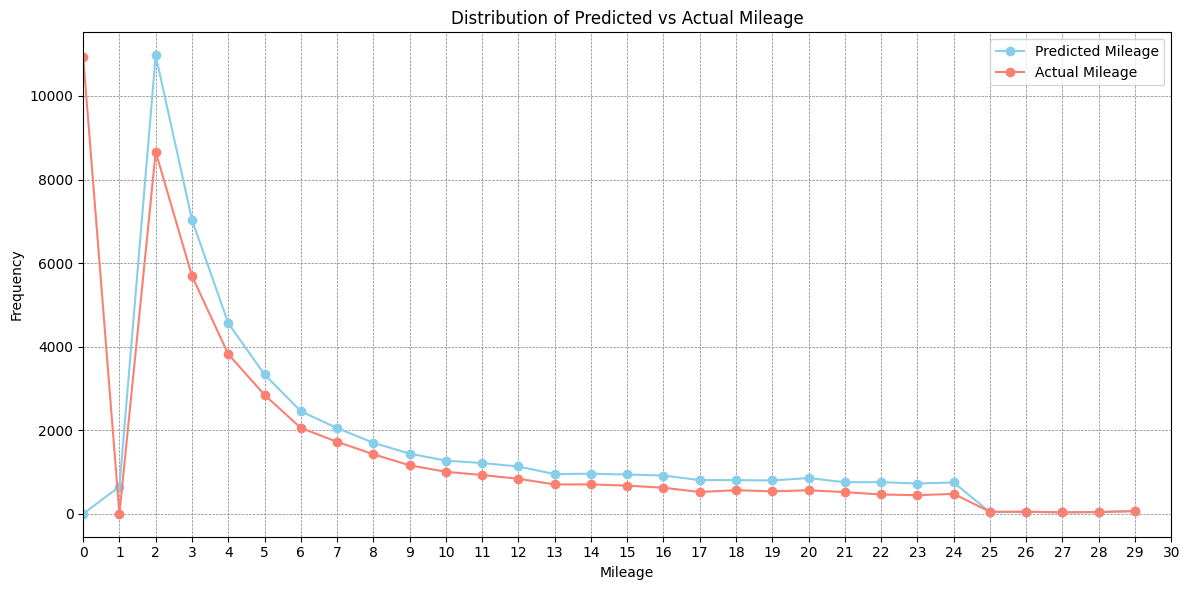

In [6]:
plot_p_a_mileage_line(uber_df)

p_a_mileage_hist.png saved!


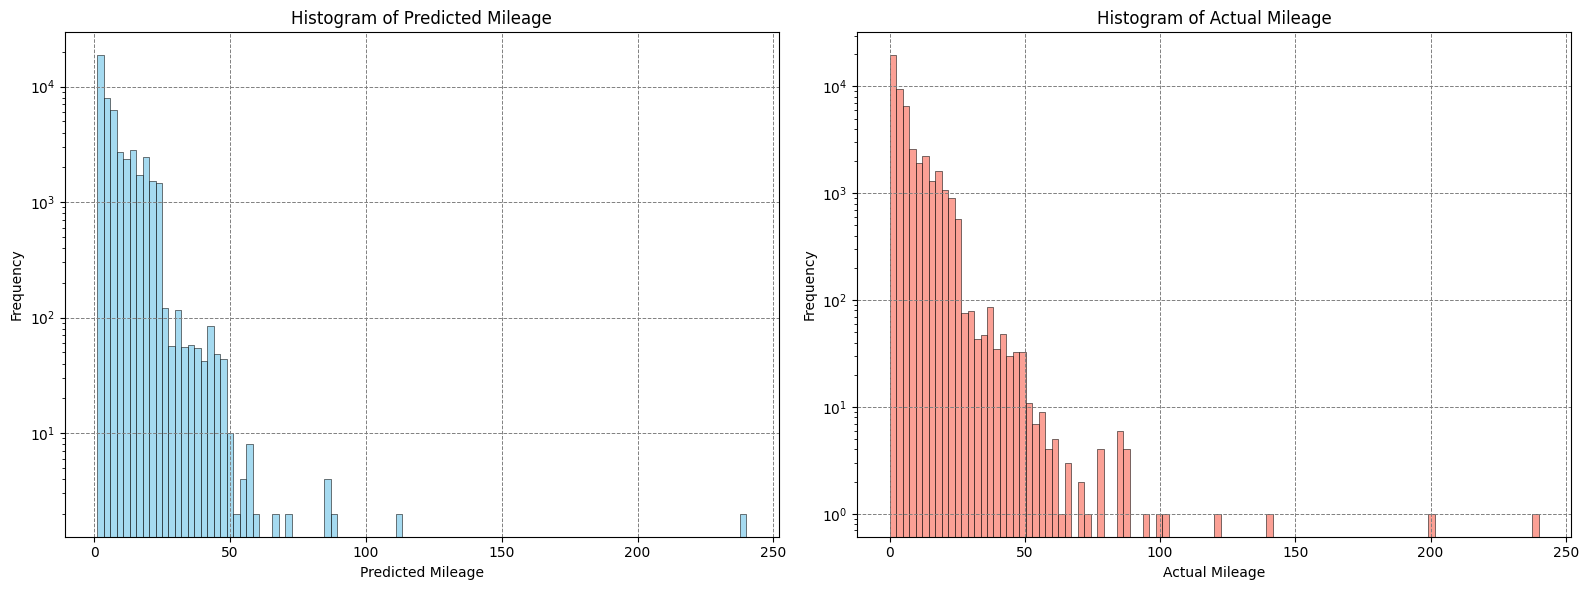

In [7]:
plot_p_a_mileage_hist(uber_df, save=True)

Pie charts saved to p_a_mileage_scatter


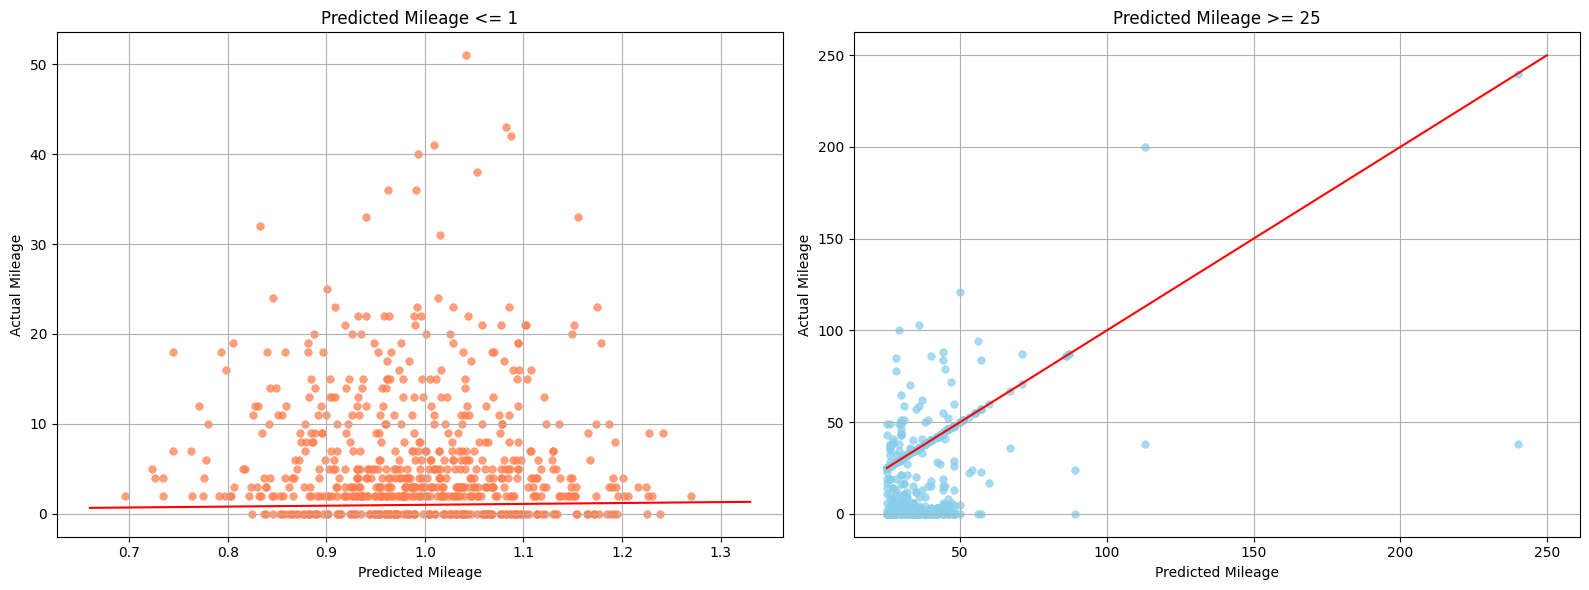

In [8]:
plot_p_a_mileage_scatter(uber_df)

Pie charts saved to p_a_mileage_pie.png


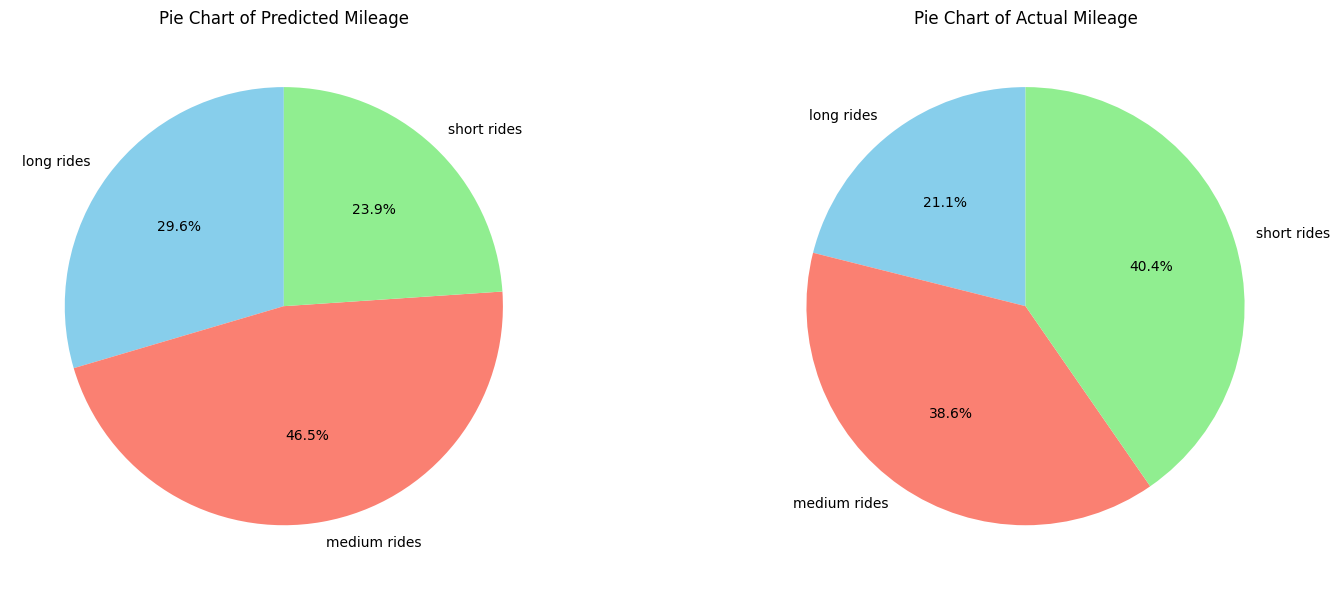

In [9]:
def categorize_mileage(mileage):
    if mileage < 3: #short rides
        return 'short rides'
    elif mileage < 10: #normal rides
        return 'medium rides'
    else: #long rides
        return 'long rides'

uber_df['P_M_Category'] = uber_df['Predicted_Mileage'].apply(categorize_mileage)
uber_df['AM_Category'] = uber_df['Actual Mileage'].apply(categorize_mileage)

def plot_p_a_mileage_pie(df, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    pm_counts = df['P_M_Category'].value_counts().sort_index()
    am_counts = df['AM_Category'].value_counts().sort_index()

    axes[0].pie(pm_counts, labels=pm_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'lightgreen'])
    axes[0].set_title('Pie Chart of Predicted Mileage')

    axes[1].pie(am_counts, labels=am_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'lightgreen'])
    axes[1].set_title('Pie Chart of Actual Mileage')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f'Pie charts saved to {save_path}')
    plt.show()

plot_p_a_mileage_pie(uber_df, save_path='p_a_mileage_pie.png')

### Determine Important Variables for Predicting or Understanding Ride Cancelling

In [10]:
def balance_train_val(X, y, test_size=0.1, validation_size=0.25, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    X_train_val_true = X_train_val[y_train_val]
    y_train_val_true = y_train_val[y_train_val]
    X_train_val_false = X_train_val[~y_train_val]
    y_train_val_false = y_train_val[~y_train_val]

    num_true_cases = y_train_val_true.shape[0]
    num_false_cases_to_keep = min(num_true_cases, y_train_val_false.shape[0])
    
    indices_to_sample = np.random.choice(X_train_val_false.shape[0], num_false_cases_to_keep, replace=False)
    X_train_val_false_sampled = X_train_val_false[indices_to_sample]
    y_train_val_false_sampled = y_train_val_false.iloc[indices_to_sample]
    
    X_train_val_balanced = np.vstack([X_train_val_true, X_train_val_false_sampled])
    y_train_val_balanced = np.concatenate([y_train_val_true, y_train_val_false_sampled])

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val_balanced, 
        y_train_val_balanced, 
        test_size=validation_size, 
        random_state=random_state
    )
    
    return X_train, X_val, y_train, y_val, X_test, y_test

def split_train_val_test(X, y, test_size=0.15, validation_size=0.15, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + validation_size, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size / (test_size + validation_size), random_state=random_state
    )
    
    return X_train, X_val, y_train, y_val, X_test, y_test

def prepare_data(df, feature_columns, target_column, bal_train_val=True):
    X = df[feature_columns]
    y = (df[target_column] == 0) # Ride Cancellation Boolean

    transformers = []
    if 'hour' in feature_columns:
        transformers.append(('hour', OneHotEncoder(), ['hour']))
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    X_preprocessed = preprocessor.fit_transform(X)

    if bal_train_val:
        X_train, X_val, y_train, y_val, X_test, y_test = balance_train_val(X_preprocessed, y)
    else:
        X_train, X_val, y_train, y_val, X_test, y_test = split_train_val_test(X_preprocessed, y)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, preprocessor

In [11]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='RandomForest', nonlinear=False, save_path=None, report=True):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    if report:
        print(f"{model_type} Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred))
        print(f"{model_type} Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)

    if not nonlinear:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'], ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'Confusion Matrix for {model_type} (Validation Set)')

    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'], ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title(f'Confusion Matrix for {model_type} (Test Set)')

    if nonlinear:
        plt.show()
        return

    if model_type == 'RandomForest':
        importances = model.feature_importances_
    elif model_type == 'SVM':
        importances = model.coef_.flatten()

    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.replace('remainder__', '') for name in feature_names]
    feature_names = [name.replace('hour__', '') for name in feature_names]

    data = [(n, i, abs(i)) for n, i in zip(feature_names, importances)]
    feature_importances = pd.DataFrame(data, columns=['Feature', 'Original_Importance', 'Absolute_Importance'])
    feature_importances = feature_importances.sort_values(by='Absolute_Importance', ascending=False)

    sns.barplot(x='Absolute_Importance', y='Feature', data=feature_importances, ax=axes[2])
    axes[2].set_title(f'Feature Importance from {model_type}')
    axes[2].set_xlabel('Importance')
    axes[2].set_ylabel('Feature')

    for i, (feature, importance) in enumerate(zip(feature_importances['Feature'], feature_importances['Original_Importance'])):
        sign = " (+)" if importance > 0 else " (-)"
        axes[2].text(
            feature_importances['Absolute_Importance'].iloc[i] + 0.01,
            i,
            sign,
            va='center',
            ha='left',
            color='black'
        )

    plt.show()

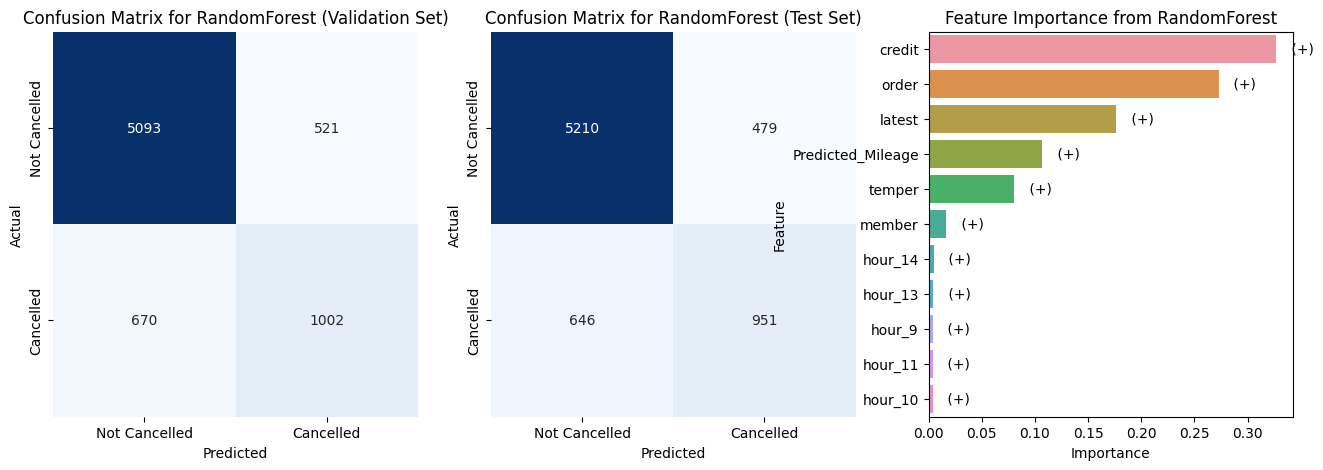

Train set size: 33999
Validation set size: 7286
Test set size: 7286

Train set distribution:
False    26327
True      7672
Name: Actual Mileage, dtype: int64

Validation set distribution:
False    5614
True     1672
Name: Actual Mileage, dtype: int64

Test set distribution:
False    5689
True     1597
Name: Actual Mileage, dtype: int64



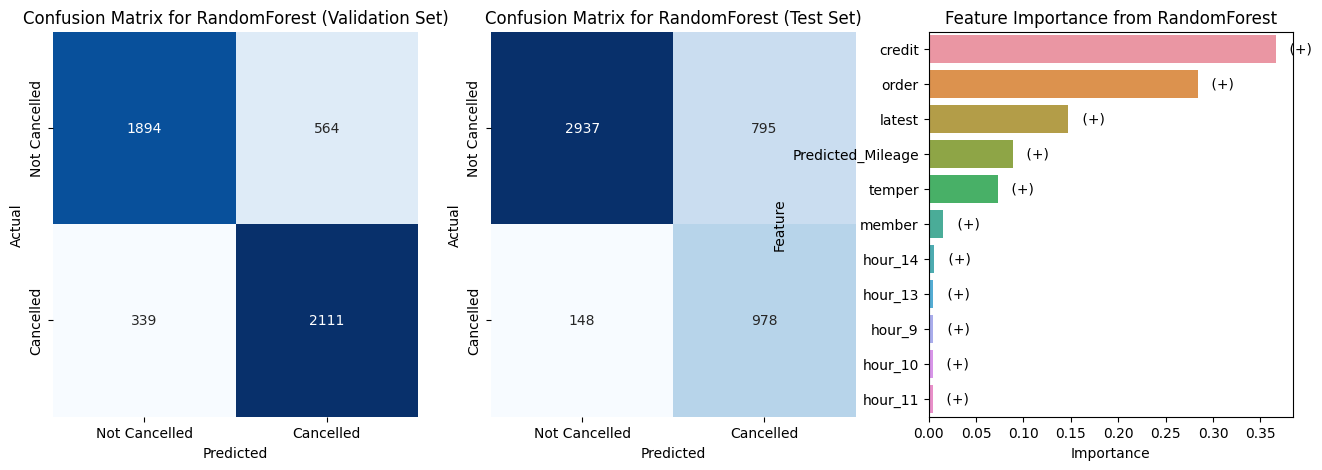

Train set size: 14722
Validation set size: 4908
Test set size: 4858

Train set distribution:
True     7365
False    7357
dtype: int64

Validation set distribution:
False    2458
True     2450
dtype: int64

Test set distribution:
False    3732
True     1126
Name: Actual Mileage, dtype: int64



In [12]:
#Training with All Features
feature_columns = ['hour', 'Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Inbalanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=False)
rf_model = RandomForestClassifier(n_estimators=256, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='RandomForest', report=False)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}\n")

print(f"Train set distribution:\n{pd.Series(y_train).value_counts()}\n")
print(f"Validation set distribution:\n{pd.Series(y_val).value_counts()}\n")
print(f"Test set distribution:\n{pd.Series(y_test).value_counts()}\n")

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)
rf_model = RandomForestClassifier(n_estimators=256, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='RandomForest', report=False)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}\n")

print(f"Train set distribution:\n{pd.Series(y_train).value_counts()}\n")
print(f"Validation set distribution:\n{pd.Series(y_val).value_counts()}\n")
print(f"Test set distribution:\n{pd.Series(y_test).value_counts()}\n")

RandomForest Classification Report (Validation Set):
               precision    recall  f1-score   support

       False       0.88      0.90      0.89      5614
        True       0.64      0.58      0.61      1672

    accuracy                           0.83      7286
   macro avg       0.76      0.74      0.75      7286
weighted avg       0.82      0.83      0.83      7286

RandomForest Classification Report (Test Set):
               precision    recall  f1-score   support

       False       0.89      0.92      0.90      5689
        True       0.66      0.59      0.62      1597

    accuracy                           0.84      7286
   macro avg       0.78      0.75      0.76      7286
weighted avg       0.84      0.84      0.84      7286



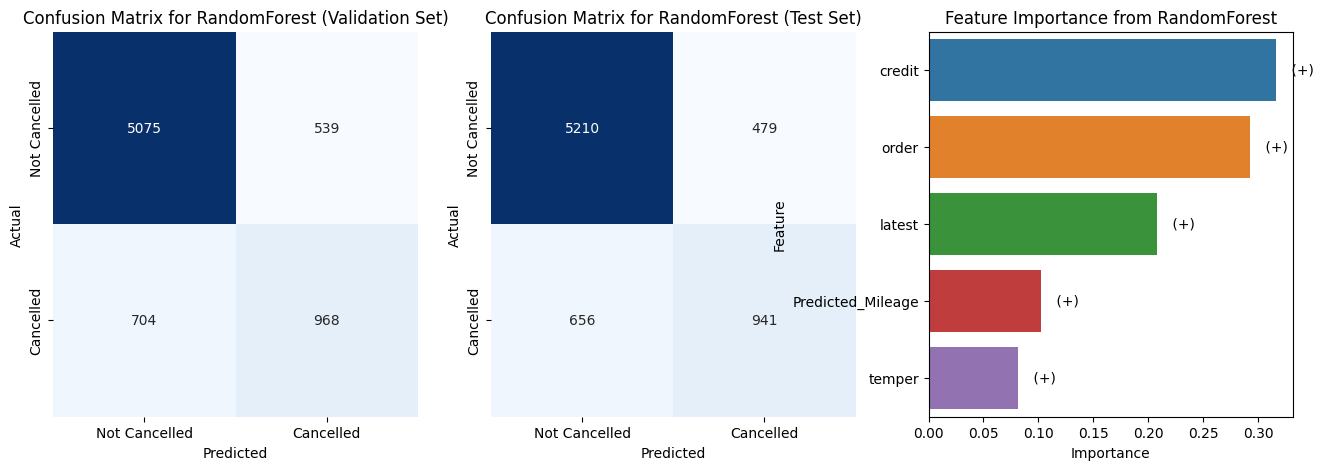

RandomForest Classification Report (Validation Set):
               precision    recall  f1-score   support

       False       0.85      0.79      0.82      2458
        True       0.80      0.86      0.83      2450

    accuracy                           0.82      4908
   macro avg       0.83      0.82      0.82      4908
weighted avg       0.83      0.82      0.82      4908

RandomForest Classification Report (Test Set):
               precision    recall  f1-score   support

       False       0.95      0.79      0.86      3732
        True       0.55      0.86      0.67      1126

    accuracy                           0.81      4858
   macro avg       0.75      0.83      0.77      4858
weighted avg       0.86      0.81      0.82      4858



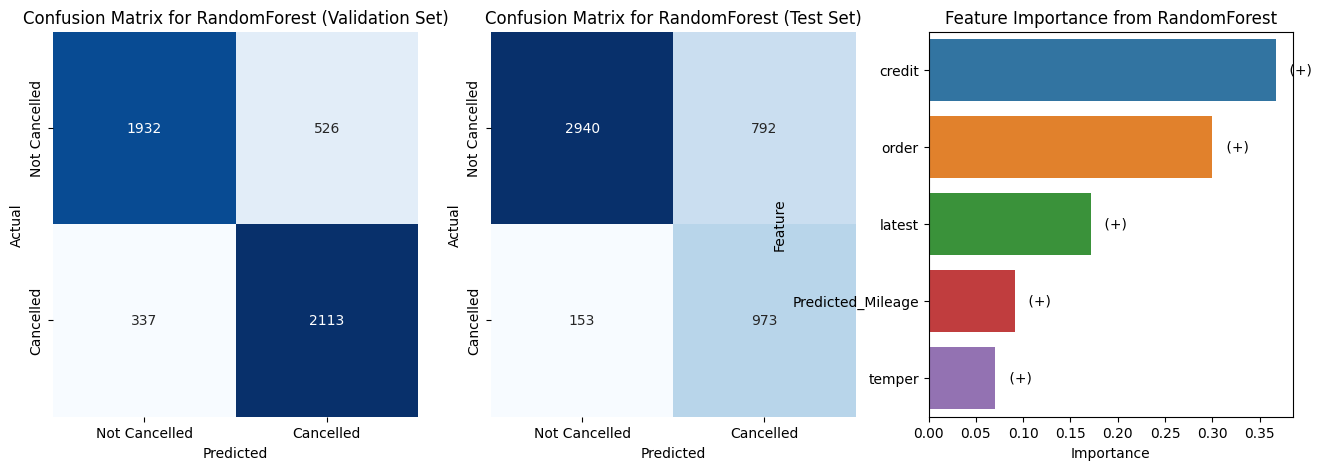

In [13]:
#Training with Select Features
feature_columns = ['Predicted_Mileage', 'credit', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Inbalanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=False)
rf_model = RandomForestClassifier(n_estimators=256, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='RandomForest', report=True)

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)
rf_model = RandomForestClassifier(n_estimators=256, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='RandomForest', report=True)

### Balanced Training for Better Recall, Fine-tuning to Improve Precision

SVM Classification Report (Validation Set):
               precision    recall  f1-score   support

       False       0.85      0.80      0.82      2458
        True       0.81      0.86      0.83      2450

    accuracy                           0.83      4908
   macro avg       0.83      0.83      0.83      4908
weighted avg       0.83      0.83      0.83      4908

SVM Classification Report (Test Set):
               precision    recall  f1-score   support

       False       0.94      0.81      0.87      3732
        True       0.57      0.84      0.68      1126

    accuracy                           0.82      4858
   macro avg       0.76      0.83      0.78      4858
weighted avg       0.86      0.82      0.83      4858



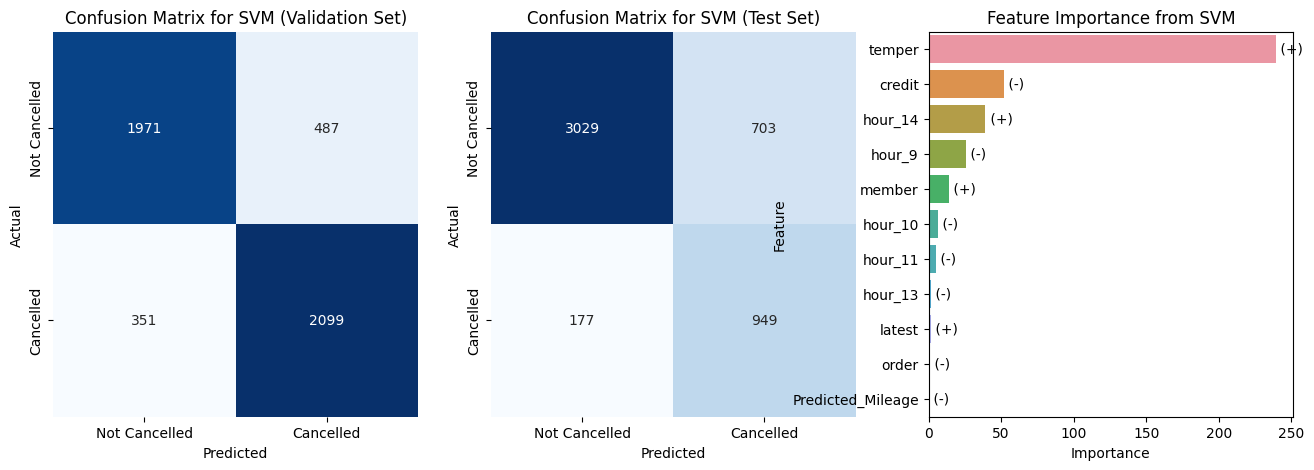

In [14]:
# Baseline
feature_columns = ['hour', 'Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)
svm_model = SVC(kernel='linear', random_state=42)
evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', save_path='base_svm_eval.png', report=True)

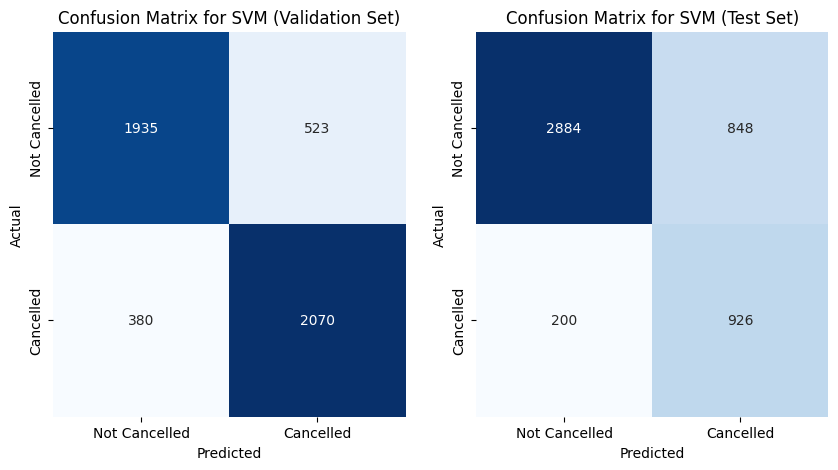

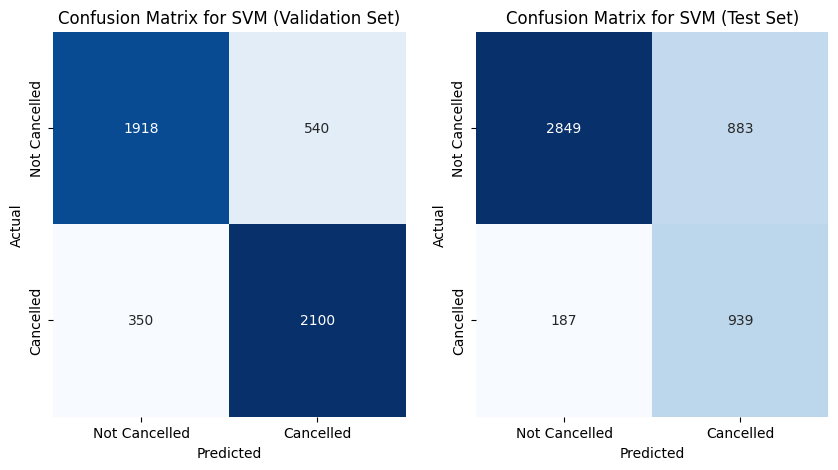

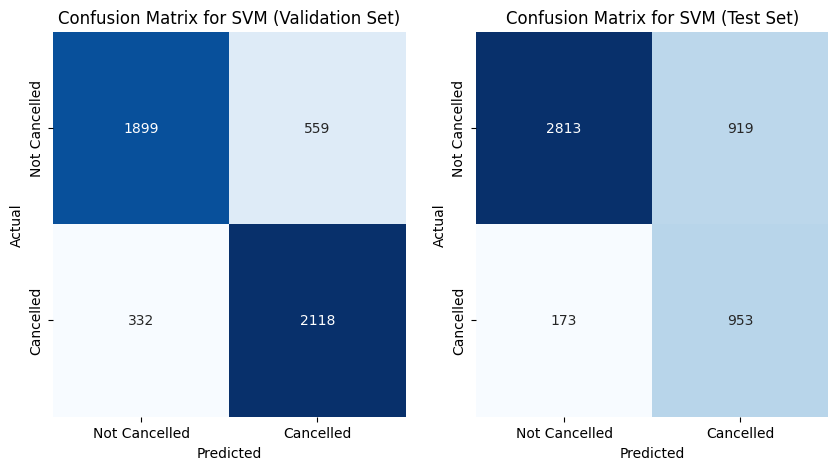

In [15]:
# Polynomial
feature_columns = ['Predicted_Mileage', 'credit', 'member', 'temper']
target_column = 'Actual Mileage'

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)

svm_model = SVC(kernel='poly', degree=2, random_state=42)
evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

svm_model = SVC(kernel='poly', degree=3, random_state=42)
evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

svm_model = SVC(kernel='poly', degree=4, random_state=42)
evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

results for gamma=0.0001, C=1


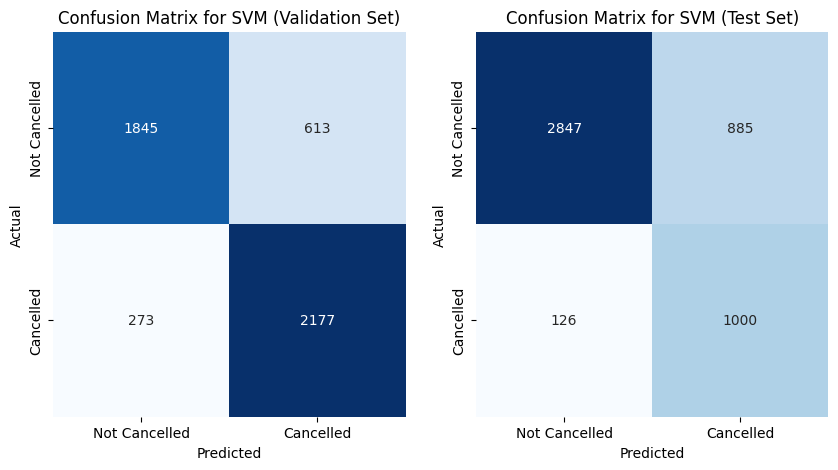

results for gamma=0.0032, C=1


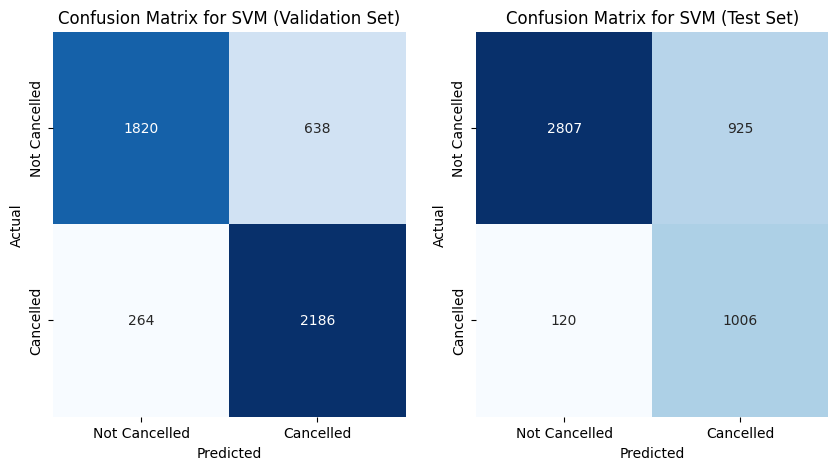

results for gamma=0.1, C=1


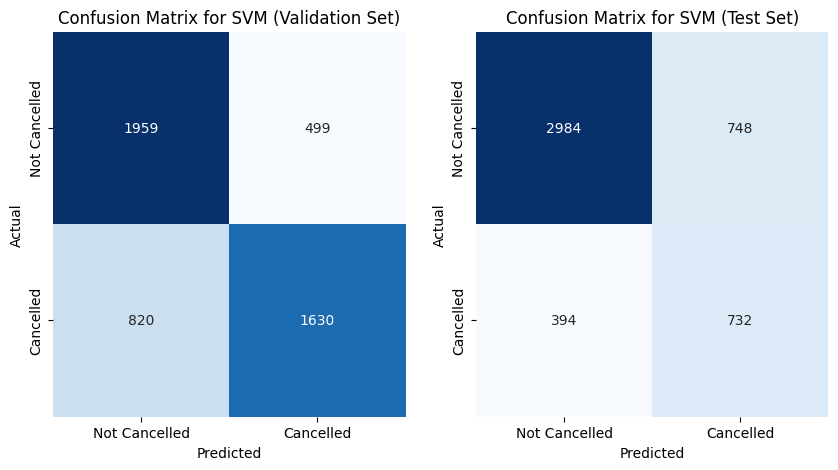

results for gamma=0.0001, C=3.2


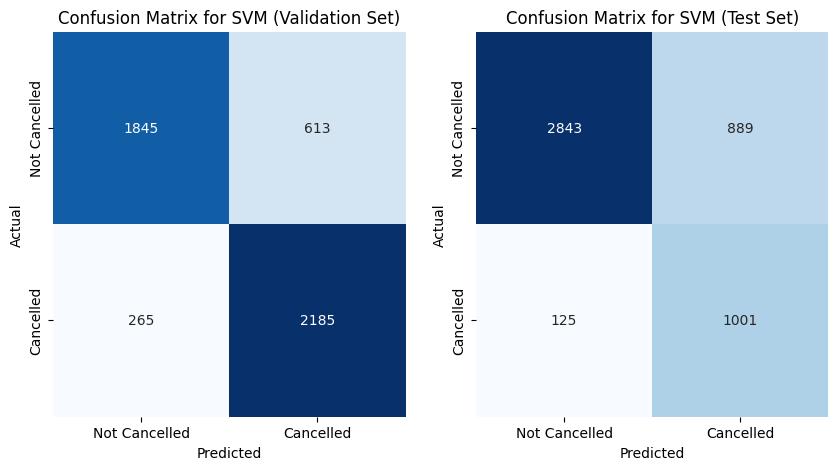

results for gamma=0.0032, C=3.2


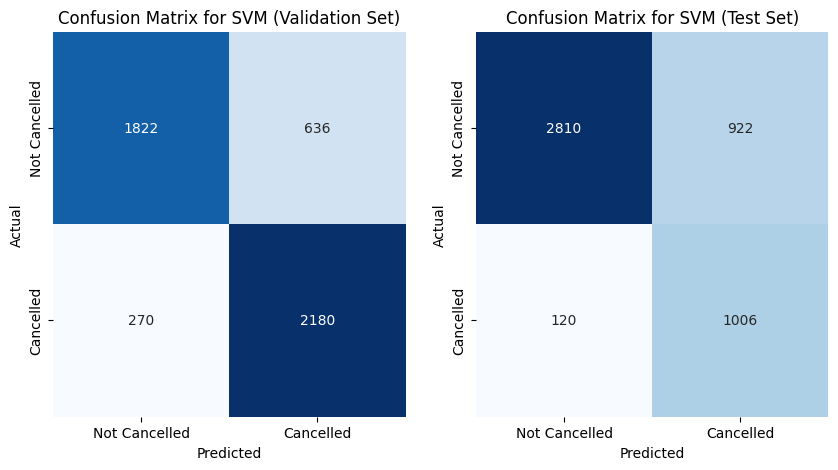

results for gamma=0.1, C=3.2


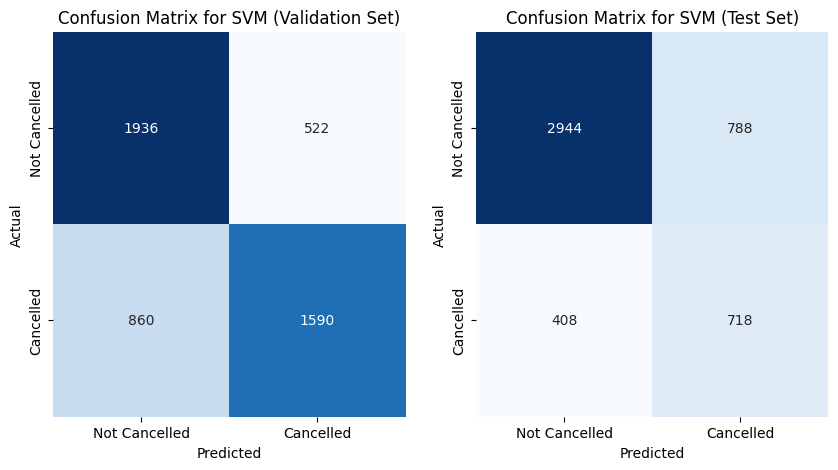

results for gamma=0.0001, C=10


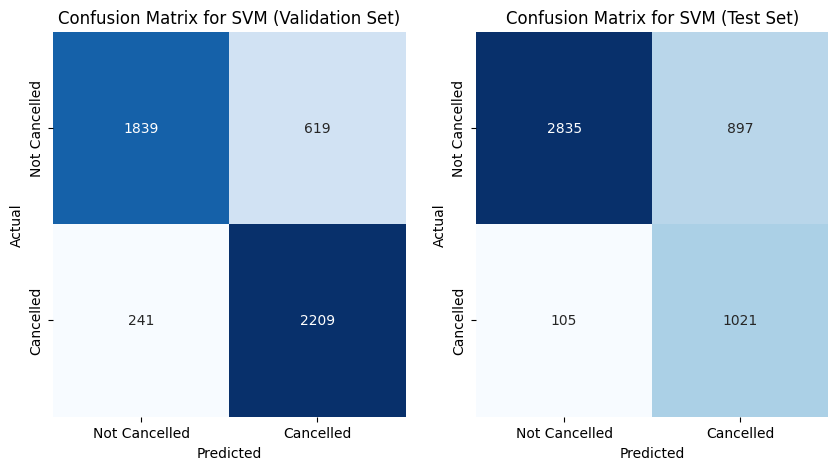

results for gamma=0.0032, C=10


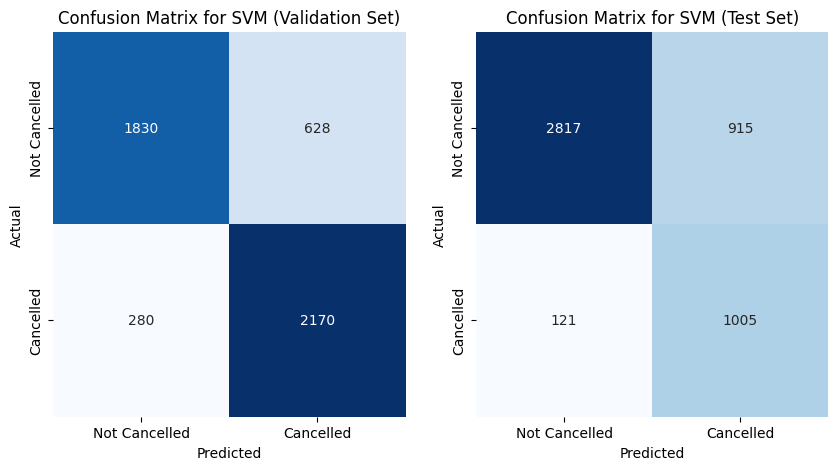

results for gamma=0.1, C=10


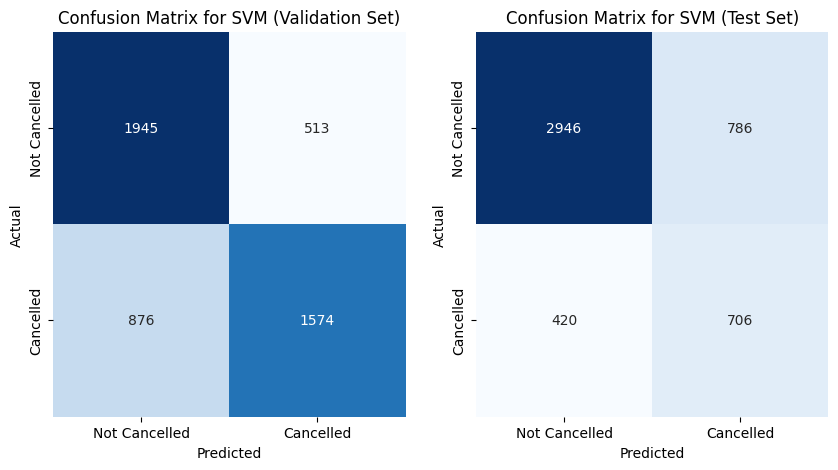

In [16]:
# RBF kernel
feature_columns = ['Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)
C_values = [1, 3.2, 10]
gamma_values = [0.0001, 0.0032, 0.1]
for C in C_values:
    for gamma in gamma_values:
        print(f"results for gamma={gamma}, C={C}")
        svm_model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

results for gamma=0.0004, C=5


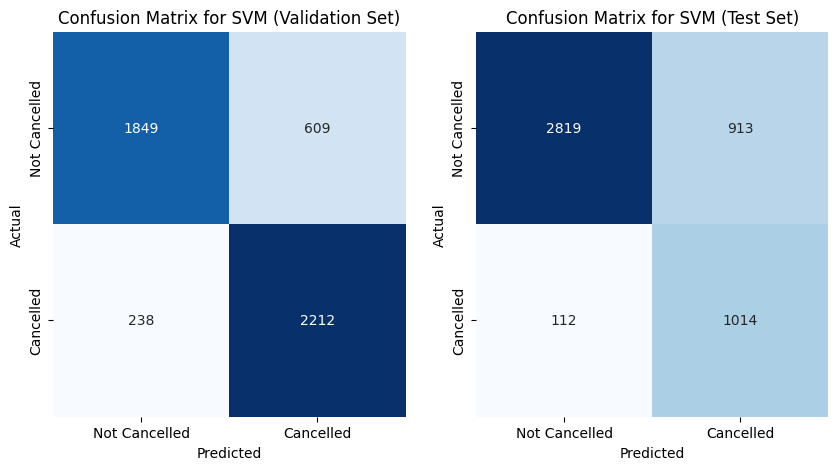

results for gamma=0.0016, C=5


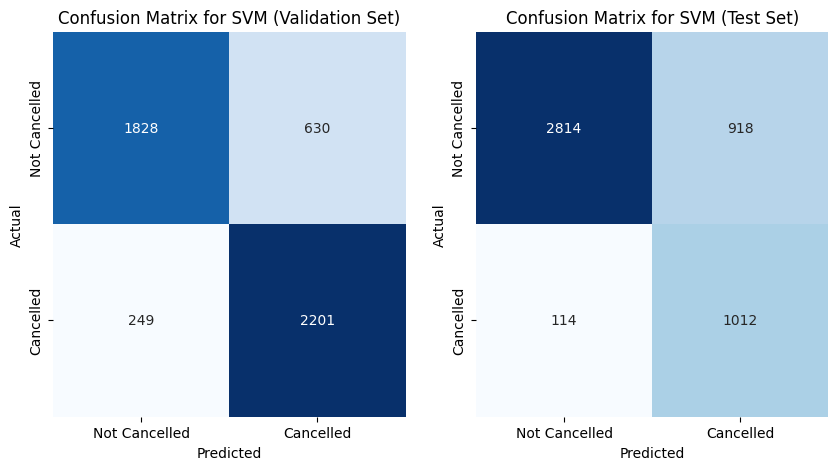

results for gamma=0.0064, C=5


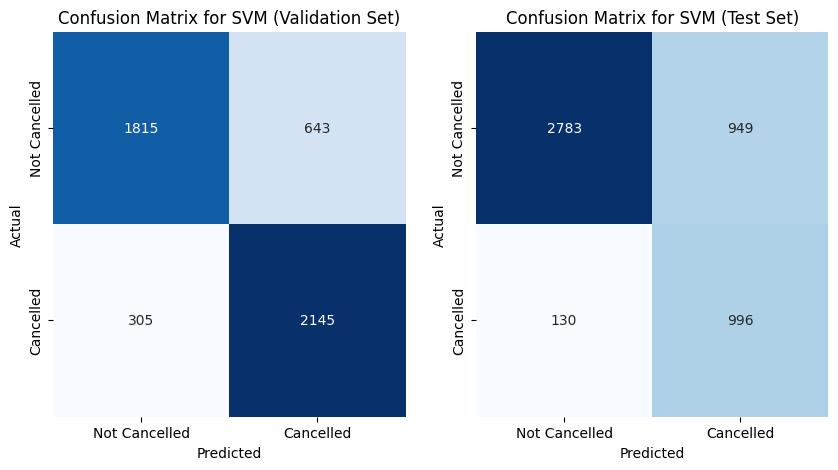

In [17]:
# RBF kernel: Gamma Tuning
feature_columns = ['Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Balanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=True)
C_values = [5]
gamma_values = [0.0004, 0.0016, 0.0064]
for C in C_values:
    for gamma in gamma_values:
        print(f"results for gamma={gamma}, C={C}")
        svm_model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

results for gamma=0.0004, C=5


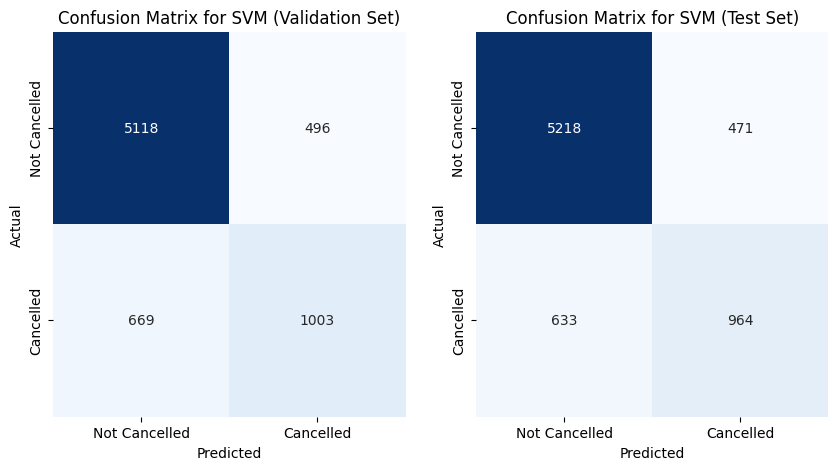

results for gamma=0.0016, C=5


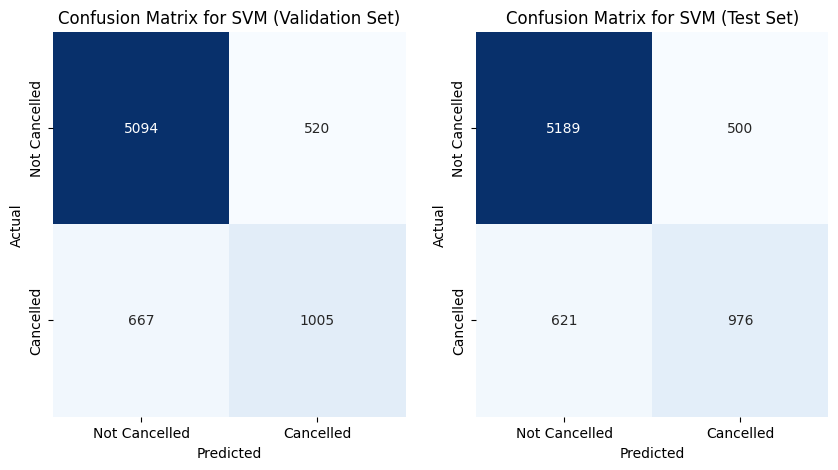

results for gamma=0.0064, C=5


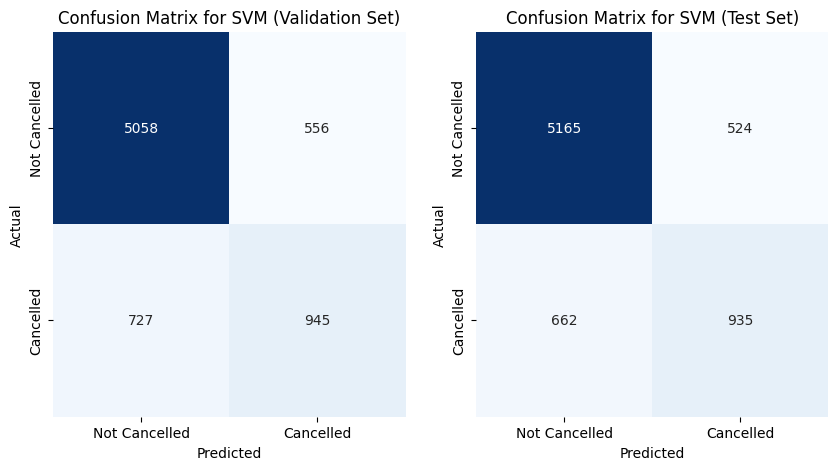

In [18]:
# RBF kernel
feature_columns = ['Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Unbalanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=False)
C_values = [5]
gamma_values = [0.0004, 0.0016, 0.0064]
for C in C_values:
    for gamma in gamma_values:
        print(f"results for gamma={gamma}, C={C}")
        svm_model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=False)

results for gamma=0.0016, C=5
SVM Classification Report (Validation Set):
               precision    recall  f1-score   support

       False       0.88      0.90      0.89      5614
        True       0.63      0.57      0.60      1672

    accuracy                           0.82      7286
   macro avg       0.75      0.73      0.74      7286
weighted avg       0.82      0.82      0.82      7286

SVM Classification Report (Test Set):
               precision    recall  f1-score   support

       False       0.89      0.91      0.90      5689
        True       0.64      0.59      0.61      1597

    accuracy                           0.84      7286
   macro avg       0.76      0.75      0.75      7286
weighted avg       0.83      0.84      0.83      7286



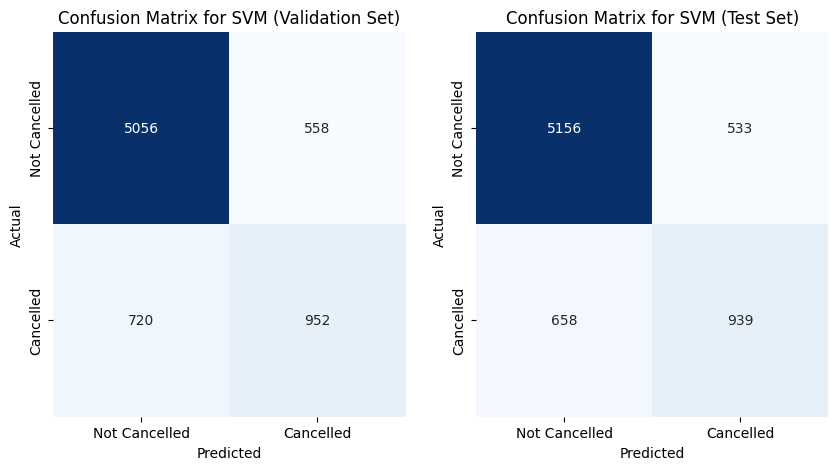

In [19]:
# Final RBF
feature_columns = ['hour', 'Predicted_Mileage', 'credit', 'member', 'temper', 'latest', 'order']
target_column = 'Actual Mileage'

# Unbalanced Training
X_train, y_train, X_val, y_val, X_test, y_test, preprocessor = prepare_data(uber_df, feature_columns, target_column, bal_train_val=False)
C_values = [5]
gamma_values = [0.0016]
for C in C_values:
    for gamma in gamma_values:
        print(f"results for gamma={gamma}, C={C}")
        evaluate_model(svm_model, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, model_type='SVM', nonlinear=True, report=True)

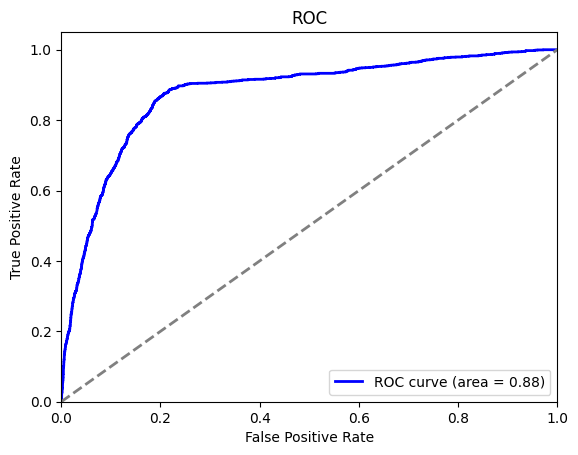

ROC AUC Score: 0.88


In [20]:
svm_model = SVC(kernel='rbf', C=5, gamma=0.0016, random_state=42, probability=True)
svm_model.fit(X_train, y_train)
y_prob = svm_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob[:, 1]) 
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")